# Определение возраста покупателей

_____
**Описание исследования.**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

_____
**Цель исследования.**

Определение возраста по фотографии
    
_____
**Задачи исследования.**
- Исследовательский анализ данных;
- обучение модели;
- анализ обученной модели.

_____
**Исходные данные.**
    
В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 
______



## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [13]:
#посмотрим на размер выборки
labels.shape

(7591, 2)

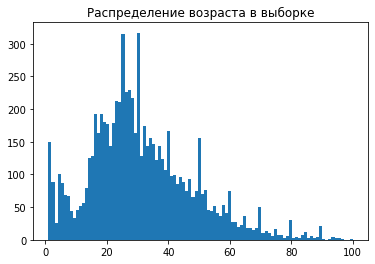

In [10]:
#Построим график распределения возраста в выборке.
plt.hist(labels['real_age'], bins=100)
plt.title('Распределение возраста в выборке')
plt.show()

При анализе возрастного состава населения принято выделять три основные возрастные группы: дети (0–14 лет), взрослые (15–64 года), пожилые (65 лет и старше).
По статистике доля детей составляет в среднем 26%, взрослых — 65%, пожилых — 9%.

Судя по графику можно сделать вывод, что наша выборка является, довольно, репрезентативной 

In [7]:
features, target = next(train_gen_flow)

print(features.shape) 

(32, 224, 224, 3)


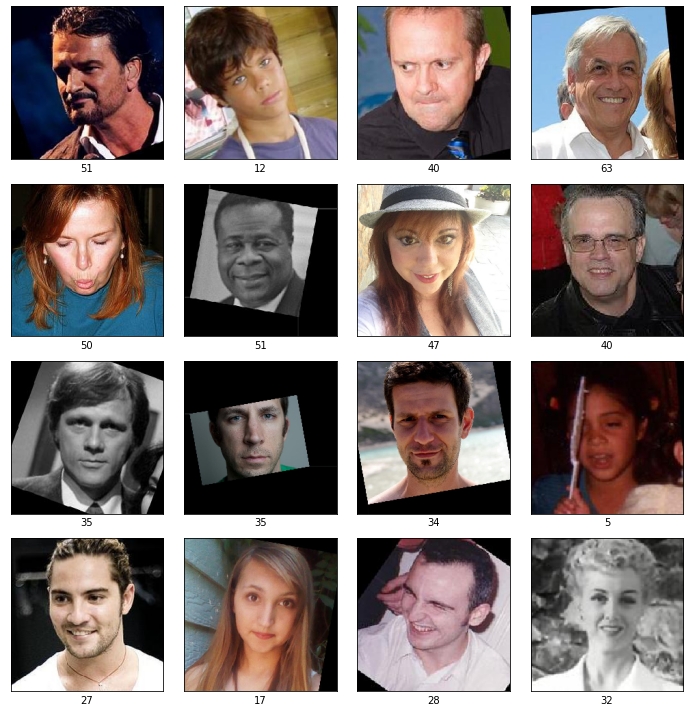

In [14]:
#Напечатаем на экране 16 фотографий и посмотрим, как устроен датасет.
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel(target[i])    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
   
    

Вывод: В нашем датафрейме 7591 фотографий с их реальным возрастом. 
Большинство фотографий людей в возрасте 20 - 41 год.

В датафрейме встречаются фотографии:
- цветные и черно-белые;
- под углом;
- лица в некоторых закрыты посторонним предмедметом;
- где лица сфотографированы сбоку или сверху;
- фотографии разных размеров.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)  
    labels = pd.read_csv(path+'labels.csv')                                    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)  
    labels = pd.read_csv(path+'labels.csv')                                    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow
 
 
def create_model(input_shape):
  optimizer = Adam(lr=0.0001)
  backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
  backbone.trainable = True
  model = Sequential()
  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation='relu'))
  model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])      
  return model
 
def train_model(model, train_data, test_data, 
                batch_size=None, 
                epochs=3, 
                steps_per_epoch=None, 
                validation_steps=None):
  model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)              
  return model

```

```

# < скопируйте результат вывода на экран сюда >
2023-05-01 18:43:45.643917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-05-01 18:43:45.646050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-05-01 18:43:46.517138: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-05-01 18:43:46.529633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-01 18:43:46.529720: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-01 18:43:46.529769: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-01 18:43:46.532128: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-05-01 18:43:46.532593: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-05-01 18:43:46.535363: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-05-01 18:43:46.536971: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-05-01 18:43:46.537049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-05-01 18:43:46.541841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-05-01 18:43:46.906064: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-05-01 18:43:46.913293: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-05-01 18:43:46.913939: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x577b260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-01 18:43:46.913974: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-01 18:43:47.080347: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x540bd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-01 18:43:47.080387: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-05-01 18:43:47.082682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-01 18:43:47.082741: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-01 18:43:47.082751: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-01 18:43:47.082778: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-05-01 18:43:47.082787: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-05-01 18:43:47.082796: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-05-01 18:43:47.082804: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-05-01 18:43:47.082811: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-05-01 18:43:47.087047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-05-01 18:43:47.087126: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-01 18:43:47.431319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-05-01 18:43:47.431372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-05-01 18:43:47.431381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-05-01 18:43:47.435852: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-01 18:43:47.435925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/3
2023-05-01 18:43:58.215726: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-01 18:43:58.583220: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 54s - loss: 212.7273 - mae: 10.5181 - val_loss: 624.7221 - val_mae: 19.9861
Epoch 2/3
356/356 - 44s - loss: 67.1983 - mae: 6.2133 - val_loss: 187.4418 - val_mae: 10.2139
Epoch 3/3
356/356 - 45s - loss: 36.8629 - mae: 4.7079 - val_loss: 87.6351 - val_mae: 7.1950
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 87.6351 - mae: 7.1950
Test MAE: 7.1950




```

## Анализ обученной модели

В данной задаче регрессии мы работали с сетью ResNet50, предобученной на датасете ImageNet. Модель обучили на 1 нейроне, который возвращает число предсказание. В качесве активации выбрали ReLU т.к. положительные прогнозы сети функция ReLU не меняет, а все отрицательные — приводит к нулю. Чисел меньше 0 быть не может.

Функцией потерь выбрали MSE т.к. зачастую нейронные сети с функцией потерь MSE обучаются быстрее.

Полученная модель позволит нам решить поставленные бизнесом задачи:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Что в свою очередь позволит повысить средний чек покупателя, предлагая покупателям необходимые им товары.